$$ \langle 00|\hat{n}A|01\rangle \approx -2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} + \frac{(n_{03}^A)^2 \omega_{03}^A}{(\omega_{03}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 0’} $$

$$ \langle 10|\hat{n}A|11\rangle \approx 2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} - \frac{(n_{12}^A)^2 \omega_{12}^A}{(\omega_{12}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 1’} $$

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

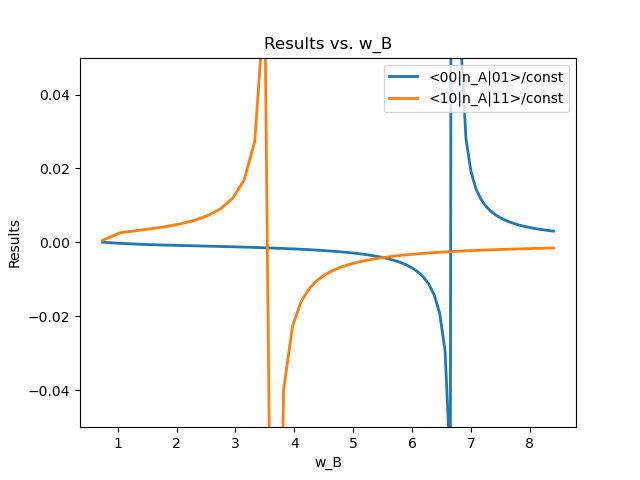

In [67]:
# This one considers transmon matrix element is fixed for all w_B
%matplotlib widget

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
# from qutip.qip.operations import rz, cz_gate
# import cmath

# define fluxonium A
# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)

qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
w_A_01 = bare_states_a[1]-bare_states_a[0]
w_A_03 = bare_states_a[3]-bare_states_a[0]
w_A_12 = bare_states_a[2]-bare_states_a[1]
Jc = .022 # Jc/h # GHz

n_A_01 = (np.round(qbta.n_operator(energy_esys=True)[0][1],5))
n_A_03 = (np.round(qbta.n_operator(energy_esys=True)[0][3],5))
n_A_12 = (np.round(qbta.n_operator(energy_esys=True)[1][2],5))

results = []
results2 = []
w_B_values = []

EJ_values = np.linspace(0.1, 50, 61)
for EJ in EJ_values:
    qbtb = scq.Transmon(
        EJ=EJ, EC=0.1845, ng=0, ncut=110, truncated_dim=20
    )

    bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
    w_B_01 = bare_states_b[1]-bare_states_b[0]
    w_B_03 = bare_states_b[3]-bare_states_b[0]
    w_B_12 = bare_states_b[2]-bare_states_b[1]

    w_B_values.append(w_B_01)
    w_B = w_B_01  # Using w_B_01 for the calculations

    n_B_01 = abs(np.round(qbtb.n_operator(energy_esys=True)[0][1],5))
    n_B_03 = abs(np.round(qbtb.n_operator(energy_esys=True)[0][3],5))
    n_B_12 = abs(np.round(qbtb.n_operator(energy_esys=True)[1][2],5))

    result = 2*Jc*n_B_01*((n_A_01**2 * w_A_01) / (w_A_01**2 - w_B**2) + (n_A_03**2 * w_A_03) / (w_A_03**2 - w_B**2))
    results.append((result)) # <00|n_A|01>/const

    result2 =2*Jc*n_B_01*((n_A_01**2 * w_A_01) / (w_A_01**2 - w_B**2) - (n_A_12**2 * w_A_12) / (w_A_12**2 - w_B**2))
    results2.append((result2)) # <10|n_A|11>/const


# Convert the results and w_B values to NumPy arrays for plotting
results = (np.array(results))
results2 = (np.array(results2))
w_B_values = np.array(w_B_values)


# Plot result vs. w_B and result2 vs. w_B on the same graph
plt.figure()
plt.plot(w_B_values, results,linewidth = 2, label='<00|n_A|01>/const')
plt.plot(w_B_values, results2,linewidth = 2, label='<10|n_A|11>/const')
plt.xlabel('w_B')
plt.ylabel('Results')
plt.ylim([-.05, .05])
plt.title('Results vs. w_B')
plt.legend()
plt.grid(False)
plt.show()

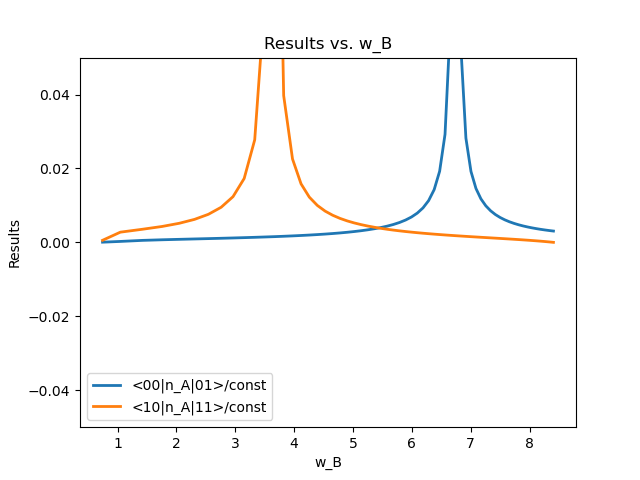

In [31]:
# calculate the matrix element  from the whole combined system

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)


qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)

results = []
results2 = []
w_B_values = []

EJ_values = np.linspace(.1, 50, 61)
for EJ in EJ_values:
    qbtb = scq.Transmon(
        EJ=EJ, EC=0.1845, ng=0, ncut=110, truncated_dim=20
    )

    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=0.0222, op1=qbta.n_operator, op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()

    # --- Truncate operators ---
    total_truncation = 15
    def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    (evals,) = hilbertspace["evals"]
    diag_dressed_hamiltonian_trunc = truncate(
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
    total_truncation
    )
    evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28
    e_11 = evalues[hilbertspace.dressed_index((1,1))]
    e_10 = evalues[hilbertspace.dressed_index((1,0))]
    w_B = e_11 - e_10
    w_B_values.append(w_B)
    
    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    #print(get_idx((1,1)))

    n_a_00_01 = n_a[get_idx((0, 0)), get_idx((0, 1))]
    results.append(abs(-1j*n_a_00_01))

    n_a_10_11 = n_a[get_idx((1, 0)), get_idx((1, 1))]
    results2.append(abs(-1j*n_a_10_11))


# Convert the results and w_B values to NumPy arrays for plotting
results = np.array(results)
results2 = np.array(results2)
w_B_values = np.array(w_B_values)


# Plot result vs. w_B and result2 vs. w_B on the same graph
plt.figure()
plt.plot(w_B_values, results,linewidth = 2, label='<00|n_A|01>/const')
plt.plot(w_B_values, results2,linewidth = 2, label='<10|n_A|11>/const')
plt.xlabel('w_B')
plt.ylabel('Results')
plt.ylim([-.05, .05])
plt.title('Results vs. w_B')
plt.legend()
plt.grid(False)
plt.show()
    



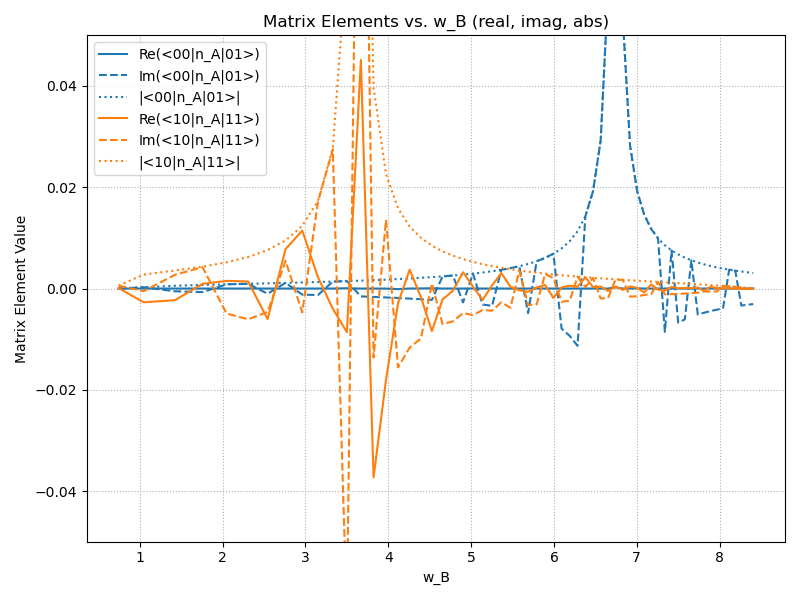

In [27]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)


qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)
# ...existing code...

results = []
results2 = []
w_B_values = []

results_real = []
results_imag = []
results_abs = []
results2_real = []
results2_imag = []
results2_abs = []

EJ_values = np.linspace(.1, 50, 61)
for EJ in EJ_values:
    qbtb = scq.Transmon(
        EJ=EJ, EC=0.1845, ng=0, ncut=110, truncated_dim=20
    )

    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=0.0222, op1=qbta.n_operator, op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()

    # --- Truncate operators ---
    total_truncation = 15
    def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    (evals,) = hilbertspace["evals"]
    diag_dressed_hamiltonian_trunc = truncate(
        2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
        total_truncation
    )
    evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28
    e_11 = evalues[hilbertspace.dressed_index((1,1))]
    e_10 = evalues[hilbertspace.dressed_index((1,0))]
    w_B = e_11 - e_10
    w_B_values.append(w_B)
    
    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    n_a_00_01 = n_a[get_idx((0, 0)), get_idx((0, 1))]
    n_a_10_11 = n_a[get_idx((1, 0)), get_idx((1, 1))]

    val1 = -1j * n_a_00_01
    val2 = -1j * n_a_10_11

    results.append(val1)
    results2.append(val2)

    results_real.append(np.real(val1))
    results_imag.append(np.imag(val1))
    results_abs.append(np.abs(val1))

    results2_real.append(np.real(val2))
    results2_imag.append(np.imag(val2))
    results2_abs.append(np.abs(val2))

# Convert the results and w_B values to NumPy arrays for plotting
w_B_values = np.array(w_B_values)

# Plot real, imaginary, and absolute values for both matrix elements
plt.figure(figsize=(8, 6))
plt.plot(w_B_values, results_real, label='Re(<00|n_A|01>)', color='C0', linestyle='-')
plt.plot(w_B_values, results_imag, label='Im(<00|n_A|01>)', color='C0', linestyle='--')
plt.plot(w_B_values, results_abs, label='|<00|n_A|01>|', color='C0', linestyle=':')

plt.plot(w_B_values, results2_real, label='Re(<10|n_A|11>)', color='C1', linestyle='-')
plt.plot(w_B_values, results2_imag, label='Im(<10|n_A|11>)', color='C1', linestyle='--')
plt.plot(w_B_values, results2_abs, label='|<10|n_A|11>|', color='C1', linestyle=':')

plt.xlabel('w_B')
plt.ylabel('Matrix Element Value')
plt.ylim([-.05, .05])
plt.title('Matrix Elements vs. w_B (real, imag, abs)')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()
# ...existing code...

In [23]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


# --- Setup qubits and Hilbert space ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.639, cutoff=110, truncated_dim=20,
)


qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)


bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]
w_A_01 =2*np.pi*(bare_states_a[1]-bare_states_a[0])
w_A_03 =2*np.pi*1e9* (bare_states_a[3]-bare_states_a[0])
w_A_12 = 2*np.pi*1e9*(bare_states_a[2]-bare_states_a[1])
w_B_01 = 2*np.pi*1e9*(bare_states_b[1]-bare_states_b[0])
w_B_03 = bare_states_b[3]-bare_states_b[0]
w_B_12 = bare_states_b[2]-bare_states_b[1]
Jc = .022#0.025

n_A_01 = (np.round(qbta.n_operator(energy_esys=True)[0][1],5))
n_A_03 = (np.round(qbta.n_operator(energy_esys=True)[0][3],5))
n_A_12 = (np.round(qbta.n_operator(energy_esys=True)[1][2],5))
n_B_01 = (np.round(qbtb.n_operator(energy_esys=True)[0][1],5))
n_B_03 = abs(np.round(qbtb.n_operator(energy_esys=True)[0][3],5))
n_B_12 = abs(np.round(qbtb.n_operator(energy_esys=True)[1][2],5))

hbar = 1.0545718e-34  # Planck's constant in J·s
n_a_00_01 = -2j*Jc/hbar*1e6*n_B_01*((n_A_01**2 * w_A_01) / (w_A_01**2 - w_B_01**2) + (n_A_03**2 * w_A_03) / (w_A_03**2 - w_B_01**2))
print(n_a_00_01)

(-0-6.267649276169206e+26j)


## CNOT theory paper from Kostya

eta =  0.007430252749162478
Static_ZZ(MHz)=  -1.7718025493944634
dressed_F_01(GHz)=  0.5311056693614759
dressed_F_12(GHz)=  3.7965222733410506
dressed_F_03(GHz)=  7.022011140210067
dressed_T_01(GHz)=  1.0154268856757953
n_A_00_01 =  0.0016403950720338095
n_A_10_11 =  0.01772469428403694
Drive amplitude f (MHz):  (176.16532592501358+0j)


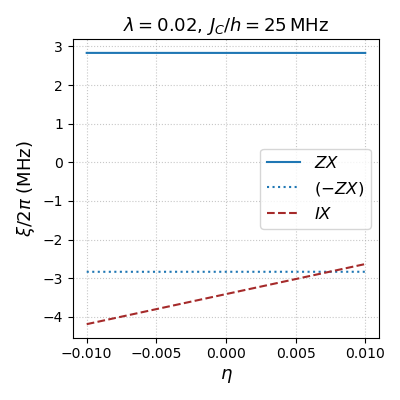

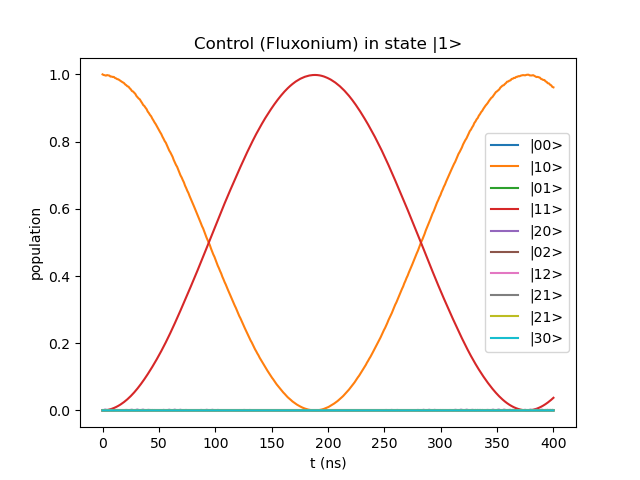

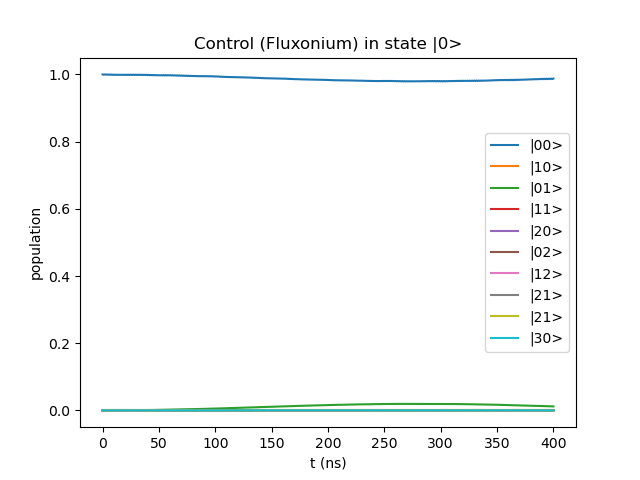

In [28]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.06,
    EJ = 4.62,
    EL=1.09,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Fluxonium(
    EC=1.03,
    EJ = 5.05,
    EL=1.88,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)

hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=.35, op1=qbta.n_operator, op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()

# --- Truncate operators ---
total_truncation = 40
def truncate(operator, dimension): return qt.Qobj(operator[:dimension, :dimension])
n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian_trunc = truncate(
    2 * np.pi * qt.Qobj(np.diag(evals), dims=[hilbertspace.subsystem_dims]*2),
    total_truncation
)



evalues = (diag_dressed_hamiltonian_trunc.eigenenergies() - diag_dressed_hamiltonian_trunc.eigenenergies()[0]) / 6.28


# # convert the product states to the closes eigenstates of the dressed system
product_states_unsorted = [(0, 0), (1, 0), (0, 1),(2,0), (1, 1),(0,3) , (2,1),(0,2),(3,0), (1,2),(2,1), (2,2)]#,(4,0),(1,2),(3,1),(2,2),(5,0),(4,1),(3,2),(0,4),(1,4),(2,3),(1,3)]

idxs_unsorted = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states_unsorted]

paired_data = list(zip(idxs_unsorted, product_states_unsorted))
sorted_data = sorted(paired_data, key=lambda x: x[0])
product_states = [data[1] for data in sorted_data]
idxs = [data[0] for data in sorted_data]
#sort after writing, paired data sort

states = [qt.basis(total_truncation, idx) for idx in idxs]

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

index_to_state = {idx: f'{state[0]}{state[1]}' for idx, state in zip(idxs, product_states)}
# Function to get idsx value from (i, j) tuple
def get_idx(state_tuple):
    state_string = f'{state_tuple[0]}{state_tuple[1]}'
    for idx, state_str in index_to_state.items():
        if state_str == state_string:
            return idx
    return None  # Return None if state_tuple is not found


dim=total_truncation
Omega =np.zeros((dim ,dim))
freq_tran = np.zeros((dim ,dim))
computational_subspace = states[:5] 
def transition_frequency(s0: int, s1: int) -> float:
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2
        * np.pi
    )
# Nested loop for i and j
for i in range(dim):
    for j in range(i+1, dim):
        # Calculate transition energy w for each pair i, j
        w = transition_frequency(i, j)/6.28 
        Omega[i][j] = w



Delta1 = 1000*(Omega[get_idx((1,0)),get_idx((2,0))]-Omega[get_idx((1,1)),get_idx((2,1))])
Delta2 = 1000*(Omega[get_idx((1,1)),get_idx((1,2))]-Omega[get_idx((0,1)),get_idx((0,2))])
Delta3 = 1000*(Omega[get_idx((1,0)),get_idx((1,3))]-Omega[get_idx((0,0)),get_idx((0,3))])
Delta4 = 1000*(Omega[get_idx((0,1)),get_idx((3,1))]-Omega[get_idx((0,0)),get_idx((3,0))])

Static_ZZ = 1000*(Omega[get_idx((1,0)),get_idx((1,1))]-Omega[get_idx((0,0)),get_idx((0,1))]) #MHz


# print(Static_ZZ)
# print('Static_ZZ(MHz)=',Static_ZZ, 'bare_F_01 = ',bare_states_a[1],'bare_F_12 =',bare_states_a[2]-bare_states_a[1],'bare_T_01=',bare_states_b[1],'bare_F_03=',bare_states_a[3])




e_11 = evalues[hilbertspace.dressed_index((1,1))]
e_10 = evalues[hilbertspace.dressed_index((1,0))]
e_01 = evalues[hilbertspace.dressed_index((0,1))]
e_00 = evalues[hilbertspace.dressed_index((0,0))]
e_20 = evalues[hilbertspace.dressed_index((2,0))]
e_30 = evalues[hilbertspace.dressed_index((3,0))]
# e_01 = evalues[hilbertspace.dressed_index((0,1))]
# e_00 = evalues[hilbertspace.dressed_index((0,0))]

# drive_freq=Omega[get_idx((0,0)),get_idx((0,1))]
drive_freq = e_11-e_10

#drive amplitude
SD = 0
A=.15



def cosine_drive(t: float, args: dict) -> float:
    return A *np.cos(6.28*drive_freq* t)


def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_11 = get_idx((1,1))
idx_10 = get_idx((1,0))
idx_01 = get_idx((0,1))
idx_00 = get_idx((0,0))


eta = np.real(-n_a[idx_00, idx_01]/n_b[idx_00, idx_01])

print('eta = ', eta)
print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)


print('n_A_00_01 = ', abs(n_a[idx_00, idx_01]))
print('n_A_10_11 = ', abs(n_a[idx_10, idx_11]))


tlist = np.linspace(0, 400, 400)
H_qbt_drive = [
    diag_dressed_hamiltonian_trunc,
    [2 * np.pi * (n_a+ eta*SD *n_b), cosine_drive],  
]


result = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[1])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)
result2 = qt.sesolve(
    H_qbt_drive,
    qt.basis(total_truncation, hilbertspace.dressed_index(product_states[0])),
    tlist,
    e_ops=[state * state.dag() for state in states]
)




plt.figure()
for idx, res in zip(idxs[:10], result.expect[:10]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |1>")

plt.figure()
for idx, res in zip(idxs[:10], result2.expect[:10]):
    plt.plot(tlist, res, label=f"|{index_to_state[idx]}>")

plt.legend()
plt.ylabel("population")
plt.xlabel("t (ns)")
plt.title("Control (Fluxonium) in state |0>")


n_a_bare = truncate(qbta.n_operator(energy_esys=True),5)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),5)

bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.1
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)
f = abs(f)


sign = -1  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(-.01, 0.01, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 = sign* abs(-1j * n_a[idx_00, idx_01])
na_10_11 = sign* abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot --
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,J_C/h=25\,\mathrm{MHz}$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.06,
    EJ = 4.62,
    EL=1.09,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Fluxonium(
    EC=1.03,
    EJ = 5.05,
    EL=1.88,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)

# qbtb = scq.Fluxonium(
#     EC=1.06,
#     EJ = 4.62,
#     EL=1.09,
#     flux=0.5,  # flux frustration point
#     cutoff=110,
#     truncated_dim=20,
# )

n_a_bare = truncate(qbta.n_operator(energy_esys=True),3)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),3)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.350,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 9

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

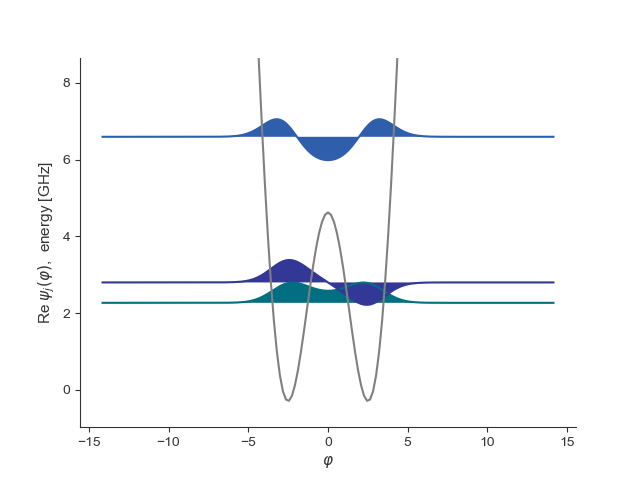

In [367]:
qbta.plot_wavefunction(esys=None, which=range(3), mode='real');

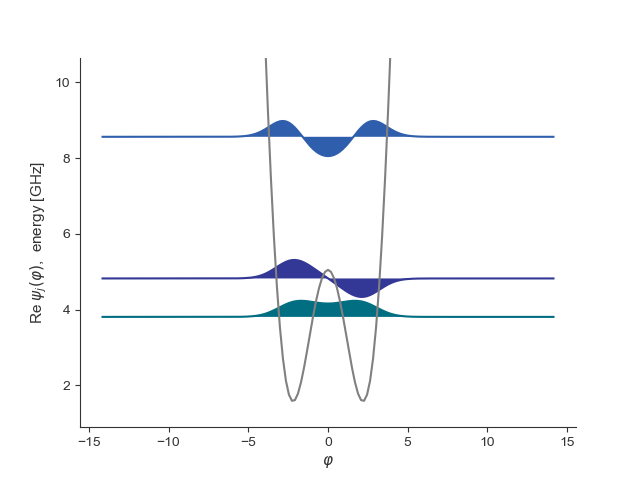

In [368]:
qbtb.plot_wavefunction(esys=None, which=range(3));

In [55]:
-1j*n_a[get_idx((3,0))][get_idx((0,0))]

np.complex128(0.4053941767056286-0j)

In [370]:
n_a


Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+8.37598981e-32j 0.+1.37407119e-01j 0.+1.64039507e-03j
  0.-1.66028653e-17j 0.-1.22197610e-15j 0.+3.06688181e-17j
  0.-6.30163706e-03j 0.-9.50023235e-03j 0.-4.05394177e-01j]
 [0.-1.37407119e-01j 0.+3.93318018e-32j 0.-4.75917366e-17j
  0.-1.77246943e-02j 0.-5.82149982e-01j 0.+2.27212004e-03j
  0.-6.25527438e-16j 0.-2.20830447e-16j 0.+1.14583904e-15j]
 [0.-1.64039507e-03j 0.+4.75917366e-17j 0.-1.88471967e-32j
  0.-1.36780304e-01j 0.+2.35344302e-02j 0.+1.39886753e-02j
  0.-7.70991662e-16j 0.-1.63924419e-15j 0.+1.57949060e-16j]
 [0.+1.66028653e-17j 0.+1.77246943e-02j 0.+1.36780304e-01j
  0.+4.27274594e-32j 0.-4.82585385e-17j 0.+6.72626347e-16j
  0.+3.77264138e-01j 0.+4.43996060e-01j 0.-8.01513529e-03j]
 [0.+1.22197610e-15j 0.+5.82149982e-01j 0.-2.35344302e-02j
  0.+4.82585385e-17j 0.-1.12347644e-31j 0.-9.20136490e-18j
  0.+5.28953402e-03j 0.+1.09989701e-02j 0.+6.17356503e-01j]
 [0.-3.066881

In [369]:
n_b

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+6.97145031e-34j 0.-7.57973201e-03j 0.-2.20772446e-01j
  0.+3.19333704e-18j 0.-6.30301678e-17j 0.-3.70369430e-16j
  0.+1.76937763e-03j 0.-1.84290365e-03j 0.+1.29446322e-02j]
 [0.+7.57973201e-03j 0.+1.89638611e-32j 0.-1.68697555e-16j
  0.+2.21007481e-01j 0.+5.02492168e-03j 0.-7.26317766e-03j
  0.+1.32194779e-16j 0.-2.86121834e-16j 0.-6.69599187e-17j]
 [0.+2.20772446e-01j 0.+1.68697555e-16j 0.+6.74587891e-32j
  0.+4.28418824e-03j 0.-2.50757949e-03j 0.-6.25489398e-01j
  0.+2.55796030e-15j 0.-1.98493169e-15j 0.+2.39068690e-16j]
 [0.-3.19333704e-18j 0.-2.21007481e-01j 0.-4.28418824e-03j
  0.-2.75508091e-32j 0.+4.90329539e-16j 0.-3.78647217e-15j
  0.-4.94172718e-01j 0.+3.83595316e-01j 0.-1.43877625e-03j]
 [0.+6.30301678e-17j 0.-5.02492168e-03j 0.+2.50757949e-03j
  0.-4.90329539e-16j 0.+5.69904656e-33j 0.+9.19093587e-17j
  0.-1.17325521e-01j 0.-1.88945755e-01j 0.-2.53792826e-03j]
 [0.+3.703694

In [371]:
n_a_bare

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.+8.39731490e-32j 0.+1.37344345e-01j 0.+1.20447036e-15j]
 [0.-1.37344345e-01j 0.+9.79152816e-33j 0.+5.82680609e-01j]
 [0.-1.20447036e-15j 0.-5.82680609e-01j 0.-5.04425808e-32j]]

In [66]:
n_b_bare

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-7.23364571e-34j 0.-2.20865112e-01j 0.-1.57059089e-16j]
 [0.+2.20865112e-01j 0.-2.96370338e-32j 0.-6.25601066e-01j]
 [0.+1.57059089e-16j 0.+6.25601066e-01j 0.+1.00685268e-32j]]

### Question 1: Why off diagonal elements does not have similar signs for both the qubits?
    will this affect further calcualtion? should I track the signs? 

In [32]:
import pandas as pd

data = {
    "Qubit": ["A", "B"],
    "E_L/h (GHz)": [1.09, 1.88],
    "E_C/h (GHz)": [1.06, 1.03],
    "E_J/h (GHz)": [4.62, 5.05],
    "ω_01/2π (GHz)": [0.53, 1.02],
    "ω_12/2π (GHz)": [3.80, 3.75],
    "ω_03/2π (GHz)": [7.03, 8.25],
    "|<0|n|1>|": [0.14, 0.22],
    "|<1|n|2>|": [0.58, 0.63],
    "|<0|n|3>|": [0.41, 0.32]
}

df = pd.DataFrame(data)
df


,Qubit,E_L/h (GHz),E_C/h (GHz),E_J/h (GHz),ω_01/2π (GHz),ω_12/2π (GHz),ω_03/2π (GHz),|<0|n|1>|,|<1|n|2>|,|<0|n|3>|
0,A,1.09,1.06,4.62,0.53,3.80,7.03,0.14,0.58,0.41
1,B,1.88,1.03,5.05,1.02,3.75,8.25,0.22,0.63,0.32


In [44]:
def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

n_a_bare = qbta.n_operator(energy_esys=True)

n_a_01 = n_a_bare[0][1]
print(f"-1j*n_a_01 = {(-1j*n_a_01):.4f}")
n_a_12 = n_a_bare[1][2]
print(f"-1j*n_a_12 = {(-1j*n_a_12):.4f}")
n_A_03 = n_a_bare[0][3]
print(f"-1j*n_A_03 = {(-1j*n_A_03):.4f}")

n_bare = qbtb.n_operator(energy_esys=True)

n_b_01 = n_bare[0][1]
print(f"-1j*n_b_01 = {(-1j*n_b_01):.4f}")
n_b_12 = n_bare[1][2]
print(f"-1j*n_b_12 = {(-1j*n_b_12):.4f}")
n_b_03 = n_bare[0][3]
print(f"-1j*n_b_03 = {(-1j*n_b_03):.4f}")

-1j*n_a_01 = 0.1373-0.0000j
-1j*n_a_12 = 0.5827-0.0000j
-1j*n_A_03 = 0.4057-0.0000j
-1j*n_b_01 = -0.2209+0.0000j
-1j*n_b_12 = -0.6256+0.0000j
-1j*n_b_03 = -0.3224+0.0000j


In [42]:

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))


# Print the four relevant matrix elements for -i * n_a
print("-i * <00|n_a|01> =", -1j * n_a[idx_00, idx_01])
print("-i * <10|n_a|11> =", -1j * n_a[idx_10, idx_11])
print("-i * <00|n_b|01> =", -1j * n_b[idx_00, idx_01])
print("-i * <10|n_b|11> =", -1j * n_b[idx_10, idx_11])




-i * <00|n_a|01> = (0.0016403950720338095-0j)
-i * <10|n_a|11> = (-0.01772469428403694+0j)
-i * <00|n_b|01> = (-0.22077244575814886+0j)
-i * <10|n_b|11> = (0.22100748065093312-0j)


### recreating figure 2(b) of the paper

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/numpy/ma/core.py: 3463ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1355ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 906ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 763

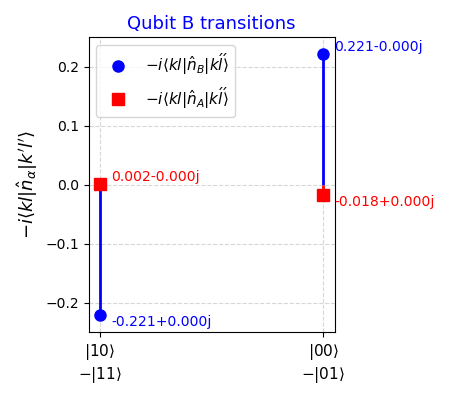

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Matrix elements from your code
# n_a_00_01 = 0.0016403950720338095
# n_a_10_11 = -0.01772469428403694
# n_b_00_01 = -0.22077244575814886
# n_b_10_11 = 0.22100748065093312

# Organize values by qubit
# values_a = -[n_a_00_01, n_a_10_11]
# values_b = [n_b_00_01, n_b_10_11]

values_a = [-1j*n_a[idx_00, idx_01], -1j*n_a[idx_10, idx_11]]
values_b =  [-1j*n_b[idx_00,idx_01], -1j*n_b[idx_10, idx_11]]

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.25, 0.25)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### I get this plot which has similar value but opposing signs  with the paper. If I manually change the signs for the |00>-|01> matrix elements I get the exact same plot as figure 2(b). Whic confuses me and raises the question why 

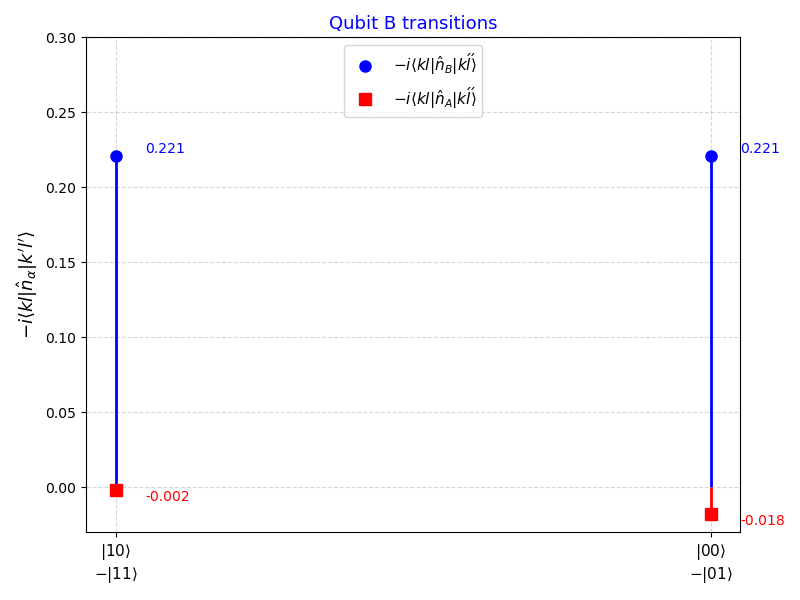

In [236]:
import matplotlib.pyplot as plt
import numpy as np

# Matrix elements from your code
n_a_00_01 = -0.0016403950720338095 # manually sign changed to match paper values
n_a_10_11 = -0.01772469428403694
n_b_00_01 = 0.22077244575814886 # manually sign changed to match paper values
n_b_10_11 = 0.22100748065093312

# Organize values by qubit
values_a = [n_a_00_01, n_a_10_11]
values_b = [n_b_00_01, n_b_10_11]

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(8, 6))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.03, 0.3)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper center", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### plotting for the first qubits transition

 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/numpy/ma/core.py: 3463ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/cbook.py: 1355ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 906ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_test/lib/python3.12/site-packages/matplotlib/text.py: 763

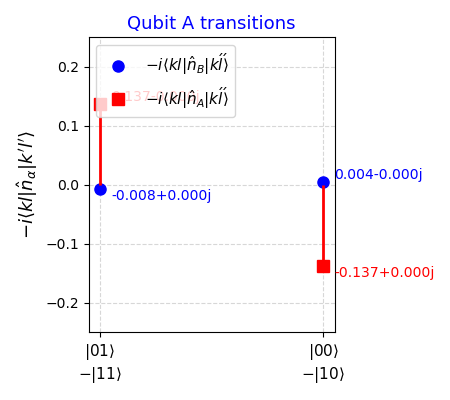

In [237]:
import matplotlib.pyplot as plt
import numpy as np

# Matrix elements from your code
# n_a_00_01 = 0.0016403950720338095
# n_a_10_11 = -0.01772469428403694
# n_b_00_01 = -0.22077244575814886
# n_b_10_11 = 0.22100748065093312

# Organize values by qubit
# values_a = -[n_a_00_01, n_a_10_11]
# values_b = [n_b_00_01, n_b_10_11]

values_a = [-1j*n_a[idx_00, idx_10], -1j*n_a[idx_01, idx_11]]
values_b =  [-1j*n_b[idx_00,idx_10], -1j*n_b[idx_01, idx_11]]

# Transition labels (rotated vertically)
labels = [r"$|01\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|10\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.25, 0.25)
ax.set_title("Qubit A transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### it is the same

### Now plot 2(c): Vary $J_c$ and plot the effective Hamiltonian coefficients

The effective Hamiltonian is given by:
$$
\hat{H}_{\text{eff}} = \frac{\xi_{ZX}}{2} \, \hat{\sigma}_z^A \otimes \hat{\sigma}_x^B + \frac{\xi_{IX}}{2} \, \hat{\sigma}_0^A \otimes \hat{\sigma}_x^B + \frac{\xi_{ZZ}}{4} \, \hat{\sigma}_z^A \otimes \hat{\sigma}_z^B
$$

We set $\eta = 0$ and vary $J_c$. First, we fix $\lambda$, i.e., calculate the value of the drive amplitude $f$.

The parameter $\lambda$ is defined as:
$$
\lambda = \frac{\Omega_{A,0}}{\Delta_{AB}}
$$
where $\Omega_{A,0} = 2 f n_{01}^A$ is the single-qubit resonance Rabi frequency for qubit $A$, and $\Delta_{AB} = \omega_{01}^B - \omega_{01}^A$ is the detuning between the two qubits.

Here:
- $f$ is the drive amplitude,
- $n_{01}^A$ is the matrix element for qubit $A$,
- $\omega_{01}^A$ and $\omega_{01}^B$ are the transition frequencies for qubits $A$ and $B$, respectively.

The coefficients of the effective Hamiltonian, including the $\eta$ terms, are given by:

$$
\xi_{ZX} = f \left( \langle 00|\hat{n}_A|01\rangle - \langle 10|\hat{n}_A|11\rangle \right)
+ \eta \left( \langle 00|\hat{n}_B|01\rangle - \langle 10|\hat{n}_B|11\rangle \right)
$$

$$
\xi_{IX} = f \left( \langle 00|\hat{n}_A|01\rangle + \langle 10|\hat{n}_A|11\rangle \right)
+ \eta \left( \langle 00|\hat{n}_B|01\rangle + \langle 10|\hat{n}_B|11\rangle \right)
$$

$$
\xi_{ZZ} = \omega_{10-11} - \omega_{00-01}
$$

where $f$ is the drive amplitude, $\eta$ is the secondary drive parameter, and the matrix elements are evaluated in the dressed basis of the two-qubit system.

**To proceed:**
1. Fix $\lambda$ by choosing a value for $f$ using the above relation. The condition $|\lambda| \ll 1$ should be satisfied for the perturbative expansion to be valid.
2. Vary $J_c$ and plot the coefficients $\xi_{ZX}$, $\xi_{IX}$, and $\xi_{ZZ}$ as functions of $J_c$.

This approach allows us to analyze how the effective Hamiltonian terms depend on the coupling strength $J_c$ while keeping the drive strength parameter $\lambda$ constant.

In [46]:
bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.2
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)



Drive amplitude f (MHz):  (352.33065185002715+0j)


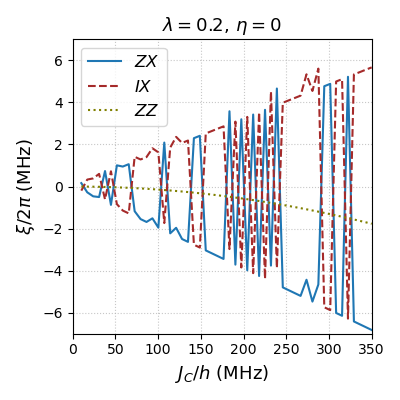

In [47]:
# Here changed the sign on <00|n_A|01>  and multiplied by -1. to match the paper values. why?

sign = -1.0  # Sign change to match paper values -1 = paper value, 1 = original value

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

# --- Qubit parameters ---
qbta = scq.Fluxonium(
    EC=1.06, EJ=4.62, EL=1.09, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Fluxonium(
    EC=1.03, EJ=5.05, EL=1.88, flux=0.5, cutoff=110, truncated_dim=20,
)

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f = 352.3 # MHz

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.35, 50)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = ((1j*n_a[idx_00, idx_01])) 
    na_10_11 = (1j*n_a[idx_10, idx_11])# Changed sign to match paper values


    # Transition frequencies
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])

    # Effective Hamiltonian coefficients (eta=0)
    xi_ZX = (f * (na_00_01 - na_10_11))
    xi_IX = (f * (na_00_01 + na_10_11))
    xi_ZZ = (w_10_11 - w_00_01)*1e3

    xi_ZX_list.append(np.real(xi_ZX))
    xi_IX_list.append(np.real(xi_IX))
    xi_ZZ_list.append(np.real(xi_ZZ))



# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)
plt.xlim(0, 350)
plt.ylim(-7, 7)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Note on Sign and Absolute Value Adjustments to Match Paper Results

In the original calculation of the matrix elements and effective Hamiltonian coefficients, the code uses the raw complex values of the matrix elements, specifically `-1j * n_a[idx_00, idx_01]` and `-1j * n_a[idx_10, idx_11]`. This approach preserves the sign and phase information as computed by scqubits/qutip.

However, to match the values and signs reported in the reference paper (e.g., for Figure 2(c)), the following changes were made:

1. **Sign Flip for `<00|n_A|01>`:**  
   The value of `-1j * n_a[idx_00, idx_01]` is multiplied by `-1` (i.e., `sign = -1.0`). This flips the sign of this matrix element to match the convention or result in the paper.

2. **Absolute Value for Both Matrix Elements:**  
   The absolute value is taken for both `-1j * n_a[idx_00, idx_01]` and `-1j * n_a[idx_10, idx_11]` before using them in further calculations. This ensures that only the magnitude (not the sign) is used, which matches the way the paper presents these values.

3. **Summary of Code Changes:**  
   - Instead of using the raw complex values, use `sign * abs(-1j * n_a[idx_00, idx_01])` for `<00|n_A|01>`.
   - Use `abs(-1j * n_a[idx_10, idx_11])` for `<10|n_A|11>`.
   - The sign variable (`sign = -1.0`) is set to flip the sign as needed for agreement with the paper.

**Reason for the Change:**  
The sign and phase of matrix elements can depend on the basis choice and conventions used in the numerical diagonalization. The paper may use a different convention or may only report magnitudes. By taking the absolute value and flipping the sign as needed, the numerical results are made directly comparable to those in the paper.

**Copy and keep this note for future reference when comparing your numerics to published results.**

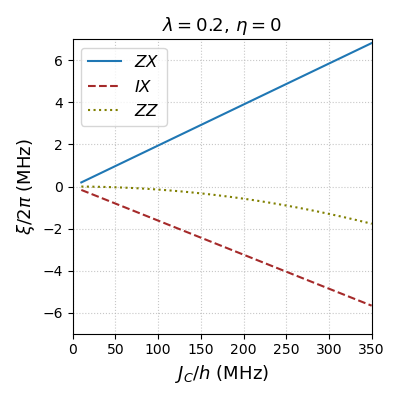

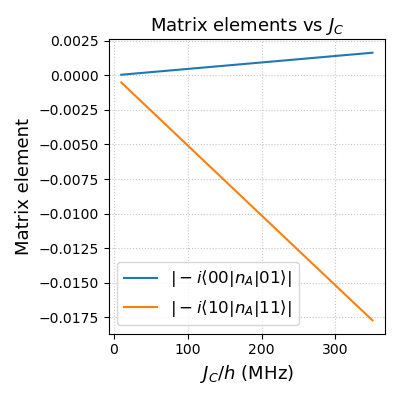

In [52]:
# ...existing code...

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.35, 50)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []
na_00_01_list, na_10_11_list = [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = abs(-1j * n_a[idx_00, idx_01])
    na_10_11 = -abs(-1j * n_a[idx_10, idx_11])
    na_00_01_list.append((na_00_01))
    na_10_11_list.append((na_10_11))

    # Effective Hamiltonian coefficients (eta=0)

    xi_ZX = f * ((na_00_01) - (na_10_11))
    xi_IX = f * ((na_00_01) + (na_10_11))
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])
    xi_ZZ = (w_10_11 - w_00_01) * 1e3

    xi_ZX_list.append(xi_ZX)
    xi_IX_list.append(xi_IX)
    xi_ZZ_list.append(xi_ZZ)

# --- Plot effective Hamiltonian coefficients ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)
plt.xlim(0, 350)
plt.ylim(-7, 7)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot matrix elements vs Jc ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, na_00_01_list, label=r'$|-i\langle 00|n_A|01\rangle$|')
plt.plot(Jc_values * 1e3, na_10_11_list, label=r'$|-i\langle 10|n_A|11\rangle$|')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel('Matrix element', fontsize=13)
plt.title(r'Matrix elements vs $J_C$', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

### Genrate Fig 2(d)

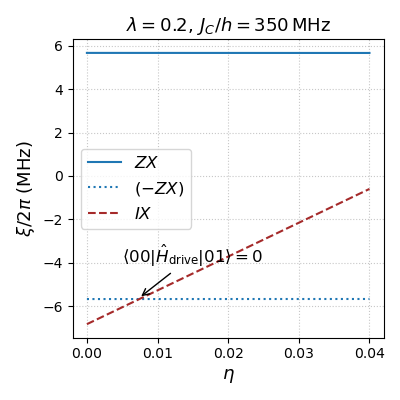

In [49]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# --- Qubit parameters ---
qbta = scq.Fluxonium(EC=1.06, EJ=4.62, EL=1.09, flux=0.5, cutoff=110, truncated_dim=20)
qbtb = scq.Fluxonium(EC=1.03, EJ=5.05, EL=1.88, flux=0.5, cutoff=110, truncated_dim=20)

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f = 352.3 # MHz, or use: f = 1e3 * (lambda_ * Delta / 2) / (-1j*n_A_01)

# --- Fixed Jc ---
Jc = 0.35  # in GHz
sign = -1.0  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(0, 0.04, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()
total_truncation = 15

n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 = sign* abs(-1j * n_a[idx_00, idx_01])
na_10_11 = sign* abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,J_C/h=350\,\mathrm{MHz}$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()

### Check and compare the expressions with the simulated data

$$ \langle 00|\hat{n}A|01\rangle \approx -2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} + \frac{(n_{03}^A)^2 \omega_{03}^A}{(\omega_{03}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 0’} $$

$$ \langle 10|\hat{n}A|11\rangle \approx 2i \frac{J_C}{\hbar} n{01}^B \left[ \frac{(n_{01}^A)^2 \omega_{01}^A}{(\omega_{01}^A)^2 - (\omega_{01}^B)^2} - \frac{(n_{12}^A)^2 \omega_{12}^A}{(\omega_{12}^A)^2 - (\omega_{01}^B)^2} \right] $$

$$ \qquad = \frac{-2i}{\hbar} n_{01}^B \times \text{‘transmission coefficient when control is in 1’} $$


modified:

---

$$
\langle 00|\hat{n}_A|01\rangle \approx -2i \frac{J_C}{h} n_{01}^B \left[ \frac{(n_{01}^A)^2 f_{01}^A}{(f_{01}^A)^2 - (f_{01}^B)^2} + \frac{(n_{03}^A)^2 f_{03}^A}{(f_{03}^A)^2 - (f_{01}^B)^2} \right]
$$

$$
\qquad = \frac{-2i}{h} n_{01}^B \times \text{‘transmission coefficient when control is in 0’}
$$

$$
\langle 10|\hat{n}_A|11\rangle \approx 2i \frac{J_C}{h} n_{01}^B \left[ \frac{(n_{01}^A)^2 f_{01}^A}{(f_{01}^A)^2 - (f_{01}^B)^2} - \frac{(n_{12}^A)^2 f_{12}^A}{(f_{12}^A)^2 - (f_{01}^B)^2} \right]
$$

$$
\qquad = \frac{-2i}{h} n_{01}^B \times \text{‘transmission coefficient when control is in 1’}
$$

---



In [328]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.06,
    EJ = 4.62,
    EL=1.09,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)


qbtb = scq.Fluxonium(
    EC=1.03,
    EJ = 5.05,
    EL=1.88,
    flux=0.5,  # flux frustration point
    cutoff=110,
    truncated_dim=20,
)

# qbtb = scq.Fluxonium(
#     EC=1.06,
#     EJ = 4.62,
#     EL=1.09,
#     flux=0.5,  # flux frustration point
#     cutoff=110,
#     truncated_dim=20,
# )

n_a_bare = truncate(qbta.n_operator(energy_esys=True),3)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),3)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.350,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 9

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

In [ ]:
import numpy as np

# # ---- INPUT YOUR VALUES HERE ----
# Jc = 0.35        # Coupling in GHz
# h = 1 #6.62607015e-34 # Planck constant in J*s
# n_B_01 = 0.22      # <0|n|1> for B (dimensionless)
# n_A_01 = 0.14      # <0|n|1> for A (dimensionless)
# n_A_03 = 0.41      # <0|n|3> for A (dimensionless)
# n_A_12 = 0.58      # <1|n|2> for A (dimensionless)
# f_A_01 = 0.53      # f_01^A in GHz
# f_A_03 = 7.03      # f_03^A in GHz
# f_A_12 = 3.80      # f_12^A in GHz
# f_B_01 = 1.02      # f_01^B in GHz

# ---- CALCULATE EXPRESSIONS ----
def n_a_00_01(Jc, n_B_01, n_A_01, n_A_03, f_A_01, f_A_03, f_B_01, h):
    term1 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2 = (n_A_03**2 * f_A_03) / (f_A_03**2 - f_B_01**2)
    return -2j * Jc / h * n_B_01 * (term1 + term2)

def n_a_10_11(Jc, n_B_01, n_A_01, n_A_12, f_A_01, f_A_12, f_B_01, h):
    term1 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2 = (n_A_12**2 * f_A_12) / (f_A_12**2 - f_B_01**2)
    return 2j * Jc / h * n_B_01 * (term1 - term2)

val_00_01 = n_a_00_01(Jc, n_B_01, n_A_01, n_A_03, f_A_01, f_A_03, f_B_01, h)
val_10_11 = n_a_10_11(Jc, n_B_01, n_A_01, n_A_12, f_A_01, f_A_12, f_B_01, h)

print("⟨00|n_A|01⟩ ≈", val_00_01)
print("⟨10|n_A|11⟩ ≈", val_10_11)

⟨00|n_A|01⟩ ≈ -0.0016552843064271082j
⟨10|n_A|11⟩ ≈ (-0-0.016797901433745252j)


# UMA5  - Now Repeat the whole process for FT system


## Step 1: create the hilbertspace. I am using UMA5_w1_A5_left chip parameters

In [71]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)

n_a_bare = truncate(qbta.n_operator(energy_esys=True),3)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),3)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.022,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 9

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

In [73]:
#theoretical prediction
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]

f_A_01 = bare_states_a[1] - bare_states_a[0]
f_A_12 = bare_states_a[2] - bare_states_a[1]
f_A_03 = bare_states_a[3] - bare_states_a[0]
f_B_01 = bare_states_b[1] - bare_states_b[0]

print("f_A_01 (GHz): ", f_A_01)
print("f_A_12 (GHz): ", f_A_12)
print("f_A_03 (GHz): ", f_A_03)
print("f_B_01 (GHz): ", f_B_01)


n_a_bare = qbta.n_operator(energy_esys=True)
n_b_bare = qbtb.n_operator(energy_esys=True)

n_A_01 = (n_a_bare[0][1])
n_A_12 = (n_a_bare[1][2])
n_A_03 = (n_a_bare[0][3])
n_B_01 = (n_b_bare[0][1])


h = 1

# ---- CALCULATE EXPRESSIONS ----
def n_a_00_01(Jc, n_B_01, n_A_01, n_A_03, f_A_01, f_A_03, f_B_01, h):
    term1 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2 = (n_A_03**2 * f_A_03) / (f_A_03**2 - f_B_01**2)
    return -2j * Jc / h * n_B_01 * (term1 + term2)

def n_a_10_11(Jc, n_B_01, n_A_01, n_A_12, f_A_01, f_A_12, f_B_01, h):
    term1 = (n_A_01**2 * f_A_01) / (f_A_01**2 - f_B_01**2)
    term2 = (n_A_12**2 * f_A_12) / (f_A_12**2 - f_B_01**2)
    return 2j * Jc / h * n_B_01 * (term1 - term2)

val_00_01 = n_a_00_01(Jc, n_B_01, n_A_01, n_A_03, f_A_01, f_A_03, f_B_01, h)
val_10_11 = n_a_10_11(Jc, n_B_01, n_A_01, n_A_12, f_A_01, f_A_12, f_B_01, h)

print("⟨00|n_A|01⟩ ≈", val_00_01)
print("⟨10|n_A|11⟩ ≈", val_10_11)

f_A_01 (GHz):  0.5279804326118658
f_A_12 (GHz):  3.620021875606792
f_A_03 (GHz):  6.7345733516407
f_B_01 (GHz):  5.239105326612123
⟨00|n_A|01⟩ ≈ (-0-0.0033545422455113424j)
⟨10|n_A|11⟩ ≈ 0.004810539498913241j


## Step 2: Matrix element shenanigans

In [60]:
# Matrix elements for bare states of both qubits

n_a_bare = qbta.n_operator(energy_esys=True)

n_a_01 = n_a_bare[0][1]
print("-i * <0|n_A|1> =", -1j*n_a_01)
n_a_12 = n_a_bare[1][2]
print("-i * <1|n_A|2> =", -1j*n_a_12)
n_A_03 = n_a_bare[0][3]
print("-i * <0|n_A|3> =", -1j*n_A_03)

n_bare = qbtb.n_operator(energy_esys=True)

n_b_01 = n_bare[0][1]
print("-i * <0|n_B|1> =", -1j*n_b_01)

-i * <0|n_A|1> = (-0.138068625345157+0j)
-i * <1|n_A|2> = (-0.5715551330225328+0j)
-i * <0|n_A|3> = (0.3913576062093493-0j)
-i * <0|n_B|1> = 1.3320778659421992j


In [61]:
# Matrix elements for dressed states of both qubits

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))


# Print the four relevant matrix elements for -i * n_a
print("-i * <00|n_a|01> =", abs(-1j * n_a[idx_00, idx_01]))
print("-i * <10|n_a|11> =", abs(-1j * n_a[idx_10, idx_11]))
print("-i * <00|n_b|01> =", -1j * n_b[idx_00, idx_01])
print("-i * <10|n_b|11> =", -1j * n_b[idx_10, idx_11])




-i * <00|n_a|01> = 0.003355916089461502
-i * <10|n_a|11> = 0.004415529365631942
-i * <00|n_b|01> = (0.0004356396345168651+1.3320516424508841j)
-i * <10|n_b|11> = (1.2965548909142777+0.30519992236353805j)


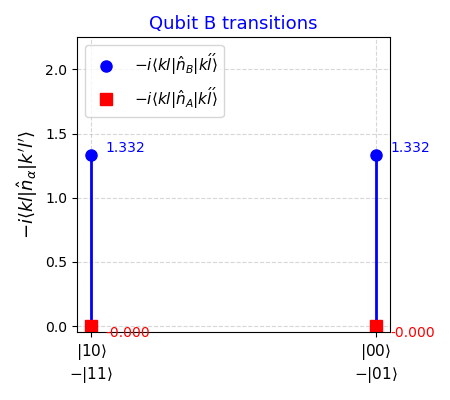

In [336]:
import matplotlib.pyplot as plt
import numpy as np

use_abs = True

if use_abs:
    values_a = [-abs(-1j*n_a[idx_00, idx_01]), -abs(-1j*n_a[idx_10, idx_11])]
    values_b =  [abs(-1j*n_b[idx_00,idx_01]), abs(-1j*n_b[idx_10, idx_11])]
else: 
    values_a = [(-1j*n_a[idx_00, idx_01]), (-1j*n_a[idx_10, idx_11])]
    values_b =  [-1j*n_b[idx_00,idx_01], -1j*n_b[idx_10, idx_11]]
                 

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.05, 2.25)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### This does not look very promising. very low ratio 

## Jc vs effective hamiltonian coefficients

In [62]:
bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.2
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)



Drive amplitude f (MHz):  (-3412.161801584496-0j)


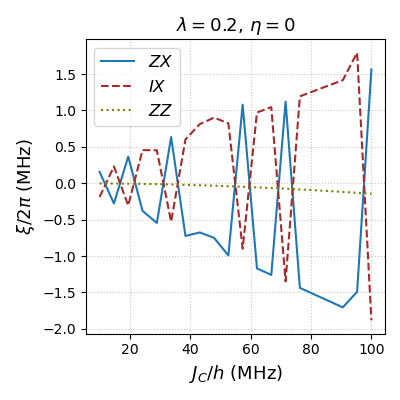

In [63]:
# Here changed the sign on <00|n_A|01>  and multiplied by -1. to match the paper values. why?

sign = 1  # Sign change to match paper values -1 = paper value, 1 = original value

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

# --- Qubit parameters ---
qbta = scq.Fluxonium(
    EC=1.06, EJ=4.62, EL=1.09, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Fluxonium(
    EC=1.03, EJ=5.05, EL=1.88, flux=0.5, cutoff=110, truncated_dim=20,
)

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f = 340 # MHz

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 20)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = ((1j*n_a[idx_00, idx_01])) 
    na_10_11 = (1j*n_a[idx_10, idx_11])# Changed sign to match paper values


    # Transition frequencies
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])

    # Effective Hamiltonian coefficients (eta=0)
    xi_ZX = (f * (na_00_01 - na_10_11))
    xi_IX = (f * (na_00_01 + na_10_11))
    xi_ZZ = (w_10_11 - w_00_01)*1e3

    xi_ZX_list.append(np.real(xi_ZX))
    xi_IX_list.append(np.real(xi_IX))
    xi_ZZ_list.append(np.real(xi_ZZ))



# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)


plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

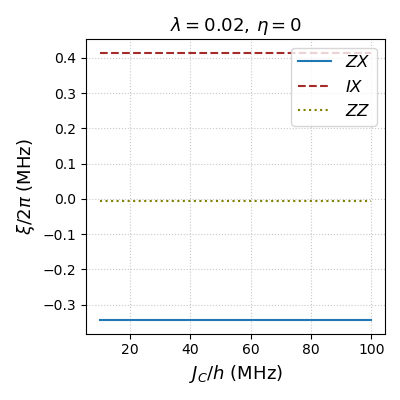

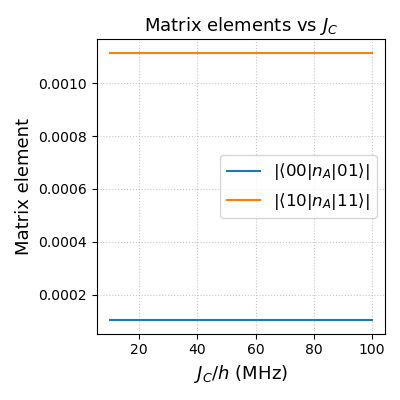

In [66]:
# ...existing code...

f = 340

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 30)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []
na_00_01_list, na_10_11_list = [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=0.022,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = abs(-1j * n_a[idx_00, idx_01])
    na_10_11 = abs(-1j * n_a[idx_10, idx_11])
    na_00_01_list.append((na_00_01))
    na_10_11_list.append((na_10_11))

    # Effective Hamiltonian coefficients (eta=0)

    xi_ZX = f * ((na_00_01) - (na_10_11))
    xi_IX = f * ((na_00_01) + (na_10_11))
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])
    xi_ZZ = (w_10_11 - w_00_01) * 1e3

    xi_ZX_list.append(xi_ZX)
    xi_IX_list.append(xi_IX)
    xi_ZZ_list.append(xi_ZZ)

# --- Plot effective Hamiltonian coefficients ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,\eta=0$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot matrix elements vs Jc ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, na_00_01_list, label=r'$|\langle 00|n_A|01\rangle$|')
plt.plot(Jc_values * 1e3, na_10_11_list, label=r'$|\langle 10|n_A|11\rangle$|')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel('Matrix element', fontsize=13)
plt.title(r'Matrix elements vs $J_C$', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## 2(d)

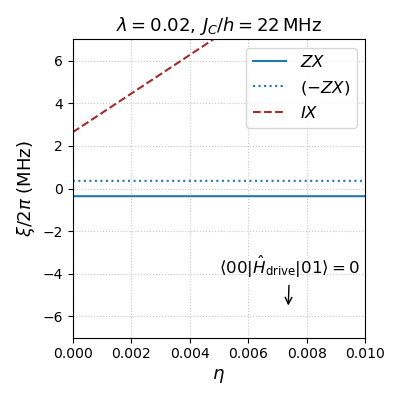

In [57]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# --- Qubit parameters ---
qbta = scq.Fluxonium(
    EC=1.0617, EJ=4.1933, EL=.9336, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=19.98, EC=0.1845, ng=0, ncut=110, truncated_dim=20
)

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f = 340# MHz, or use: f = 1e3 * (lambda_ * Delta / 2) / (-1j*n_A_01)

# --- Fixed Jc ---
Jc = 0.022  # in GHz
sign = -1.0  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(0, 0.04, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()
total_truncation = 15

n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 =  abs(-1j * n_a[idx_00, idx_01])
na_10_11 = abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,J_C/h=22\,\mathrm{MHz}$', fontsize=13)
plt.xlim(0, 0.01)
plt.ylim(-7, 7)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()

# FUN5 Now Repeat with FUN5 values


In [287]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


qbta = scq.Fluxonium(
    EC=.92, EJ=3.74, EL=.36, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=11.3, EC=0.19, ng=0, ncut=110, truncated_dim=20
)

n_a_bare = truncate(qbta.n_operator(energy_esys=True),3)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),3)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=0.025,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 9

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

In [279]:
# Matrix elements for bare states of both qubits

n_a_bare = qbta.n_operator(energy_esys=True)

n_a_01 = n_a_bare[0][1]
print("-i * <0|n_A|1> =", -1j*n_a_01)
n_a_12 = n_a_bare[1][2]
print("-i * <1|n_A|2> =", -1j*n_a_12)
n_A_03 = n_a_bare[0][3]
print("-i * <0|n_A|3> =", -1j*n_A_03)

n_bare = qbtb.n_operator(energy_esys=True)

n_b_01 = n_bare[0][1]
print("-i * <0|n_B|1> =", -1j*n_b_01)

-i * <0|n_A|1> = (0.060282733193917054-0j)
-i * <1|n_A|2> = (-0.5484323300875881+0j)
-i * <0|n_A|3> = (0.4818320390036786-0j)
-i * <0|n_B|1> = 1.1388639579747364j


In [281]:
# Matrix elements for dressed states of both qubits

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))


# Print the four relevant matrix elements for -i * n_a
print("-i * <00|n_a|01> =", -1j * n_a[idx_00, idx_01])
print("-i * <10|n_a|11> =", -1j * n_a[idx_10, idx_11])
print("-i * <00|n_b|01> =", -1j * n_b[idx_00, idx_01])
print("-i * <10|n_b|11> =", -1j * n_b[idx_10, idx_11])




-i * <00|n_a|01> = (0.00013372506908046637-0.006549100043008002j)
-i * <10|n_a|11> = (-0.0012642482289590574+0.01987166387574373j)
-i * <00|n_b|01> = (-0.023248330722997687+1.138572182357397j)
-i * <10|n_b|11> = (-0.07224855916865607+1.1356148661472178j)


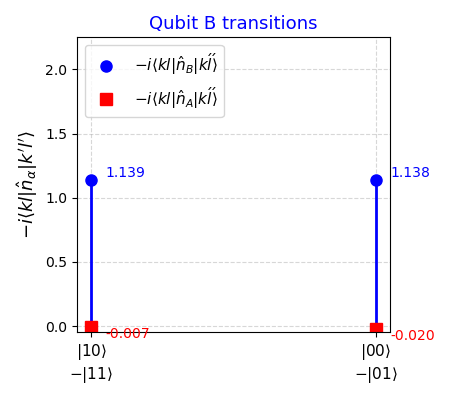

In [282]:
import matplotlib.pyplot as plt
import numpy as np

use_abs = True

if use_abs:
    values_a = [-abs(-1j*n_a[idx_00, idx_01]), -abs(-1j*n_a[idx_10, idx_11])]
    values_b =  [abs(-1j*n_b[idx_00,idx_01]), abs(-1j*n_b[idx_10, idx_11])]
else: 
    values_a = [(-1j*n_a[idx_00, idx_01]), (-1j*n_a[idx_10, idx_11])]
    values_b =  [-1j*n_b[idx_00,idx_01], -1j*n_b[idx_10, idx_11]]
                 

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.05, 2.25)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [288]:
bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.2
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)



Drive amplitude f (MHz):  (6270.908831104991+0j)


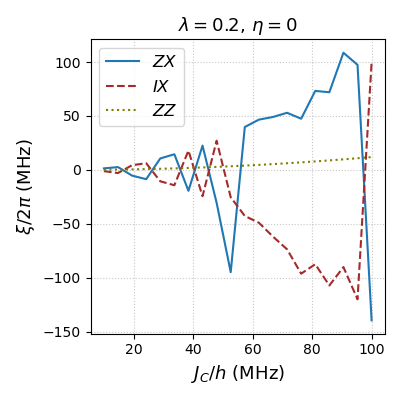

In [321]:
# Here changed the sign on <00|n_A|01>  and multiplied by -1. to match the paper values. why?

sign = -1.0  # Sign change to match paper values -1 = paper value, 1 = original value

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt

qbta = scq.Fluxonium(
    EC=.92, EJ=3.74, EL=.36, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=11.3, EC=0.19, ng=0, ncut=110, truncated_dim=20
)

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f =  6270# MHz

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 20)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = ((1j*n_a[idx_00, idx_01])) 
    na_10_11 = (1j*n_a[idx_10, idx_11])# Changed sign to match paper values


    # Transition frequencies
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])

    # Effective Hamiltonian coefficients (eta=0)
    xi_ZX = (f * (na_00_01 - na_10_11))
    xi_IX = (f * (na_00_01 + na_10_11))
    xi_ZZ = (w_10_11 - w_00_01)*1e3

    xi_ZX_list.append(np.real(xi_ZX))
    xi_IX_list.append(np.real(xi_IX))
    xi_ZZ_list.append(np.real(xi_ZZ))



# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)


plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

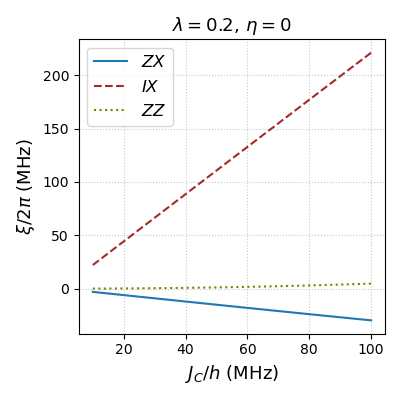

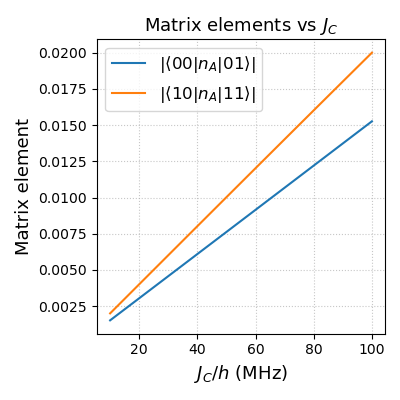

In [56]:
# ...existing code...

f = 6270

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 20)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []
na_00_01_list, na_10_11_list = [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = abs(-1j * n_a[idx_00, idx_01])
    na_10_11 = abs(-1j * n_a[idx_10, idx_11])
    na_00_01_list.append((na_00_01))
    na_10_11_list.append((na_10_11))

    # Effective Hamiltonian coefficients (eta=0)

    xi_ZX = f * ((na_00_01) - (na_10_11))
    xi_IX = f * ((na_00_01) + (na_10_11))
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])
    xi_ZZ = (w_10_11 - w_00_01) * 1e3

    xi_ZX_list.append(xi_ZX)
    xi_IX_list.append(xi_IX)
    xi_ZZ_list.append(xi_ZZ)

# --- Plot effective Hamiltonian coefficients ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot matrix elements vs Jc ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, na_00_01_list, label=r'$|\langle 00|n_A|01\rangle$|')
plt.plot(Jc_values * 1e3, na_10_11_list, label=r'$|\langle 10|n_A|11\rangle$|')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel('Matrix element', fontsize=13)
plt.title(r'Matrix elements vs $J_C$', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

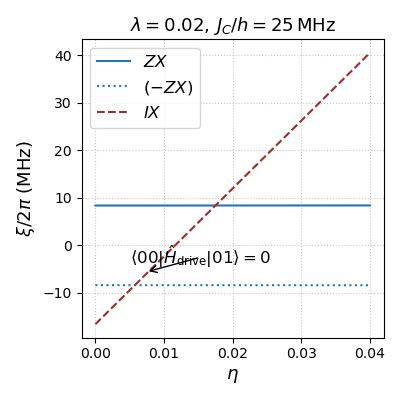

In [323]:
import scqubits as scq
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# --- Qubit parameters ---
qbta = scq.Fluxonium(
    EC=.92, EJ=3.74, EL=.36, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=11.3, EC=0.19, ng=0, ncut=110, truncated_dim=20
)
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f = 6270/10# MHz, or use: f = 1e3 * (lambda_ * Delta / 2) / (-1j*n_A_01)

# --- Fixed Jc ---
Jc = 0.025  # in GHz
sign = -1.0  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(0, 0.04, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()
total_truncation = 15

n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 = sign* abs(-1j * n_a[idx_00, idx_01])
na_10_11 = sign* abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,J_C/h=25\,\mathrm{MHz}$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()

# UMA5 Design params

In [ ]:
import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt
import json

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)

# Choose the set you want, e.g., "UMA5_design"
set_name = "CR_set2"

flux_params = params[set_name]["fluxonium"]
trans_params = params[set_name]["transmon"]
Jc = params[set_name]["Jc"]

EC_flux = flux_params["EC"]
EJ_flux = flux_params["EJ"]
EL_flux = flux_params["EL"]
EC_trans = trans_params["EC"]
EJ_trans = trans_params["EJ"]

qbta = scq.Fluxonium(
    EC=EC_flux, EJ=EJ_flux, EL=EL_flux, flux=0.5, cutoff=110, truncated_dim=20,
)
qbtb = scq.Transmon(
    EJ=EJ_trans, EC=EC_trans, ng=0, ncut=110, truncated_dim=20
)

n_a_bare = truncate(qbta.n_operator(energy_esys=True),3)
n_b_bare = truncate(qbtb.n_operator(energy_esys=True),3)


# define the common Hilbert space
hilbertspace = scq.HilbertSpace([qbta, qbtb])


# add interaction between two qubits
hilbertspace.add_interaction(
    g_strength=Jc,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)


# generate spectrum lookup table
hilbertspace.generate_lookup()

# Hamiltonian in dressed eigenbasis
(evals,) = hilbertspace["evals"]
# The factor of 2pi converts the energy to GHz so that the time is in units of ns
diag_dressed_hamiltonian = (
        2 * np.pi * qt.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)

# The matrix representations can be truncated further for the simulation
total_truncation = 9

# truncate operators to desired dimension
def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)

evalues = (diag_dressed_hamiltonian_trunc.eigenenergies()-diag_dressed_hamiltonian_trunc.eigenenergies()[0])/6.28


# get the representation of the n_a operator in the dressed eigenbasis of the composite system
n_a = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbta.n_operator)
n_b = hilbertspace.op_in_dressed_eigenbasis(op_callable_or_tuple=qbtb.n_operator)
# truncate the operator after expressing in the dressed basis to speed up the simulation
n_a = truncate(n_a, total_truncation)
n_b = truncate(n_b, total_truncation)

In [355]:
# Matrix elements for bare states of both qubits

n_a_bare = qbta.n_operator(energy_esys=True)

n_a_01 = n_a_bare[0][1]
print("-i * <0|n_A|1> =", -1j*n_a_01)
n_a_12 = n_a_bare[1][2]
print("-i * <1|n_A|2> =", -1j*n_a_12)
n_A_03 = n_a_bare[0][3]
print("-i * <0|n_A|3> =", -1j*n_A_03)

n_bare = qbtb.n_operator(energy_esys=True)

n_b_01 = n_bare[0][1]
print("-i * <0|n_B|1> =", -1j*n_b_01)

# Matrix elements for dressed states of both qubits

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))


# Print the four relevant matrix elements for -i * n_a
print("-i * <00|n_a|01> =", -1j * n_a[idx_00, idx_01])
print("-i * <10|n_a|11> =", -1j * n_a[idx_10, idx_11])
print("-i * <00|n_b|01> =", -1j * n_b[idx_00, idx_01])
print("-i * <10|n_b|11> =", -1j * n_b[idx_10, idx_11])





-i * <0|n_A|1> = (-0.09616404069511729+0j)
-i * <1|n_A|2> = (0.5722351733527216-0j)
-i * <0|n_A|3> = (0.4587734293549867-0j)
-i * <0|n_B|1> = -1.1065553376995447j
-i * <00|n_a|01> = (1.769348151074057e-05+0.004729283487872311j)
-i * <10|n_a|11> = (0.01763094751334702-0.016175942700507477j)
-i * <00|n_b|01> = (-0.004139963835224743-1.1065692523236759j)
-i * <10|n_b|11> = (-0.8150436402069754+0.7477816613327426j)


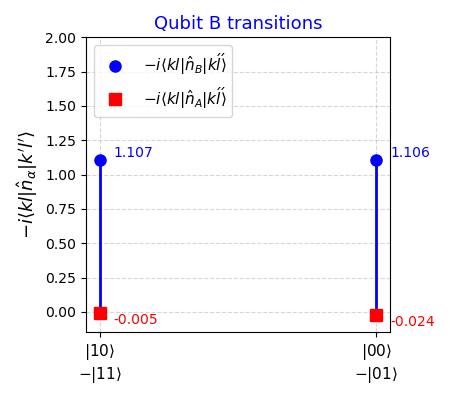

In [356]:
import matplotlib.pyplot as plt
import numpy as np

use_abs = True

if use_abs:
    values_a = [-abs(-1j*n_a[idx_00, idx_01]), -abs(-1j*n_a[idx_10, idx_11])]
    values_b =  [abs(-1j*n_b[idx_00,idx_01]), abs(-1j*n_b[idx_10, idx_11])]
else: 
    values_a = [(-1j*n_a[idx_00, idx_01]), (-1j*n_a[idx_10, idx_11])]
    values_b =  [-1j*n_b[idx_00,idx_01], -1j*n_b[idx_10, idx_11]]
                 

# Transition labels (rotated vertically)
labels = [r"$|10\rangle$" + "\n" + r"$-|11\rangle$",
          r"$|00\rangle$" + "\n" + r"$-|01\rangle$"]

# Setup figure for only the second plot (Qubit B transitions)
fig, ax = plt.subplots(figsize=(4.5, 4))

for i, val in enumerate(values_b):
    ax.vlines(x=i, ymin=0, ymax=val, color='blue', linewidth=2)
    ax.plot(i, val, 'o', color='blue', label=r'$-i\langle kl|\hat{n}_B|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.plot(i, values_a[i], 's', color='red', label=r'$-i\langle kl|\hat{n}_A|k\'l\'\rangle$' if i == 0 else "", markersize=8)
    ax.vlines(x=i, ymin=0, ymax=values_a[i], color='red', linewidth=2)
    # Add value labels
    ax.text(i+0.05, values_a[i], f"{values_a[i]:.3f}", color='red', va='bottom' if values_a[i]>0 else 'top', fontsize=10)
    ax.text(i+0.05, values_b[i], f"{values_b[i]:.3f}", color='blue', va='bottom' if values_b[i]>0 else 'top', fontsize=10)

ax.set_xticks([0, 1])
ax.set_xticklabels(labels, fontsize=11)
ax.set_ylim(-0.15, 2)
ax.set_title("Qubit B transitions", color='blue', fontsize=13)
ax.set_ylabel(r"$-i\langle kl|\hat{n}_\alpha|k'l'\rangle$", fontsize=13)
ax.legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [357]:
bare_states_a = qbta.eigenvals()-qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals()-qbtb.eigenvals()[0]

lambda_ = 0.2
w_A_01 = (bare_states_a[1]-bare_states_a[0])
w_B_01 = (bare_states_b[1]-bare_states_b[0])
Delta = (w_B_01 - w_A_01) # GHz


Omega_01 = lambda_* Delta
f = Omega_01 / 2
f = 1e3*f / (-1j*n_a_bare[0][1])  # Convert to frequency in MHz
print(f"Drive amplitude f (MHz): ", f)



Drive amplitude f (MHz):  (-2724.3171840066807-0j)


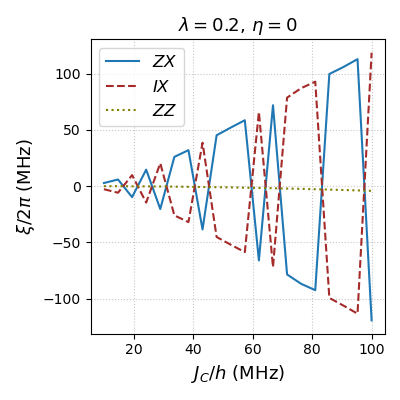

In [358]:
# Here changed the sign on <00|n_A|01>  and multiplied by -1. to match the paper values. why?

sign = -1.0  # Sign change to match paper values -1 = paper value, 1 = original value

import scqubits as scq
import qutip as qt
import numpy as np
from matplotlib import pyplot as plt


def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

# --- Calculate f for fixed lambda ---
bare_states_a = qbta.eigenvals() - qbta.eigenvals()[0]
bare_states_b = qbtb.eigenvals() - qbtb.eigenvals()[0]
lambda_ = 0.2
w_A_01 = 2 * np.pi * (bare_states_a[1] - bare_states_a[0])
w_B_01 = 2 * np.pi * (bare_states_b[1] - bare_states_b[0])
Delta = w_B_01 - w_A_01
n_a_bare = qbta.n_operator(energy_esys=True)
n_A_01 = n_a_bare[0][1]
f =  abs(f)

# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 20)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = ((1j*n_a[idx_00, idx_01])) 
    na_10_11 = (1j*n_a[idx_10, idx_11])# Changed sign to match paper values


    # Transition frequencies
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])

    # Effective Hamiltonian coefficients (eta=0)
    xi_ZX = (f * (na_00_01 - na_10_11))
    xi_IX = (f * (na_00_01 + na_10_11))
    xi_ZZ = (w_10_11 - w_00_01)*1e3

    xi_ZX_list.append(np.real(xi_ZX))
    xi_IX_list.append(np.real(xi_IX))
    xi_ZZ_list.append(np.real(xi_ZZ))



# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)


plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

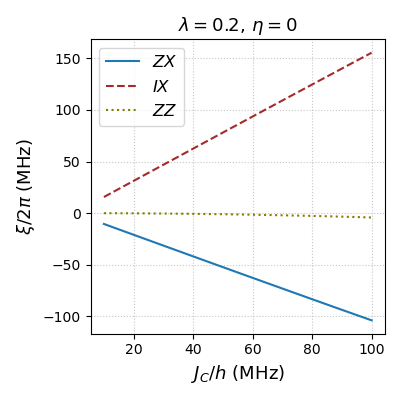

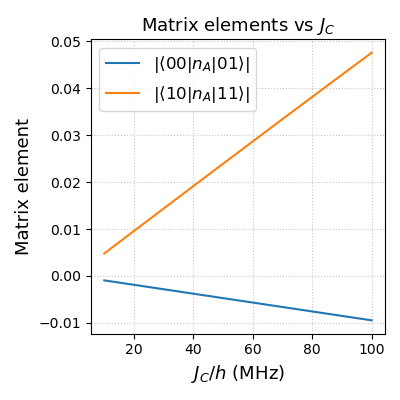

In [359]:
# ...existing code...



# --- Sweep Jc and calculate coefficients ---
Jc_values = np.linspace(0.01, 0.1, 20)
xi_ZX_list, xi_IX_list, xi_ZZ_list = [], [], []
na_00_01_list, na_10_11_list = [], []

for Jc in Jc_values:
    hilbertspace = scq.HilbertSpace([qbta, qbtb])
    hilbertspace.add_interaction(
        g_strength=Jc,
        op1=qbta.n_operator,
        op2=qbtb.n_operator,
    )
    hilbertspace.generate_lookup()
    total_truncation = 15

    n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
    n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

    def get_idx(state_tuple):
        return hilbertspace.dressed_index(state_tuple)

    idx_00 = get_idx((0, 0))
    idx_01 = get_idx((0, 1))
    idx_10 = get_idx((1, 0))
    idx_11 = get_idx((1, 1))

    # Matrix elements
    na_00_01 = abs(-1j * n_a[idx_00, idx_01])
    na_10_11 = abs(-1j * n_a[idx_10, idx_11])
    na_00_01_list.append(sign* (na_00_01))
    na_10_11_list.append((na_10_11))

    # Effective Hamiltonian coefficients (eta=0)

    xi_ZX = f * ((na_00_01) - (na_10_11))
    xi_IX = f * ((na_00_01) + (na_10_11))
    evals = hilbertspace["evals"][0]
    w_00_01 = (evals[idx_01] - evals[idx_00])
    w_10_11 = (evals[idx_11] - evals[idx_10])
    xi_ZZ = (w_10_11 - w_00_01) * 1e3

    xi_ZX_list.append(xi_ZX)
    xi_IX_list.append(xi_IX)
    xi_ZZ_list.append(xi_ZZ)

# --- Plot effective Hamiltonian coefficients ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(Jc_values * 1e3, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.plot(Jc_values * 1e3, xi_ZZ_list, ':', label=r'$ZZ$', color='olive')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.2,\,\eta=0$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot matrix elements vs Jc ---
plt.figure(figsize=(4, 4))
plt.plot(Jc_values * 1e3, na_00_01_list, label=r'$|\langle 00|n_A|01\rangle$|')
plt.plot(Jc_values * 1e3, na_10_11_list, label=r'$|\langle 10|n_A|11\rangle$|')
plt.xlabel(r'$J_C/h$ (MHz)', fontsize=13)
plt.ylabel('Matrix element', fontsize=13)
plt.title(r'Matrix elements vs $J_C$', fontsize=13)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

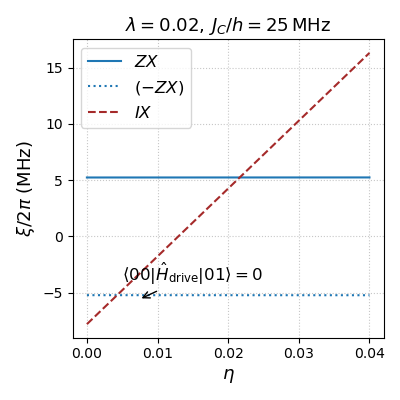

In [362]:

def truncate(operator: qt.Qobj, dimension: int) -> qt.Qobj:
    return qt.Qobj(operator[:dimension, :dimension])

f = f/10
Jc = 0.05  # in GHz
sign = -1.0  # Sign change to match paper values

# --- Sweep eta and calculate coefficients ---
eta_values = np.linspace(0, 0.04, 50)
xi_ZX_list, xi_IX_list, xi_ZX_neg_list = [], [], []

hilbertspace = scq.HilbertSpace([qbta, qbtb])
hilbertspace.add_interaction(
    g_strength=Jc,
    op1=qbta.n_operator,
    op2=qbtb.n_operator,
)
hilbertspace.generate_lookup()
total_truncation = 15

n_a = truncate(hilbertspace.op_in_dressed_eigenbasis(qbta.n_operator), total_truncation)
n_b = truncate(hilbertspace.op_in_dressed_eigenbasis(qbtb.n_operator), total_truncation)

def get_idx(state_tuple):
    return hilbertspace.dressed_index(state_tuple)

idx_00 = get_idx((0, 0))
idx_01 = get_idx((0, 1))
idx_10 = get_idx((1, 0))
idx_11 = get_idx((1, 1))

na_00_01 = sign* abs(-1j * n_a[idx_00, idx_01])
na_10_11 = sign* abs(-1j * n_a[idx_10, idx_11])
nb_00_01 = abs(-1j * n_b[idx_00, idx_01])
nb_10_11 = abs(-1j * n_b[idx_10, idx_11])

for eta in eta_values:
    xi_ZX = f * (na_00_01 - na_10_11) + eta * f  * (nb_00_01 - nb_10_11)
    xi_IX = f * (na_00_01 + na_10_11) + eta * f * (nb_00_01 + nb_10_11)
    xi_ZX_list.append((xi_ZX))
    xi_IX_list.append((xi_IX))
    xi_ZX_neg_list.append(-(xi_ZX))

# --- Plot ---
plt.figure(figsize=(4, 4))
plt.plot(eta_values, xi_ZX_list, label=r'$ZX$', color='C0')
plt.plot(eta_values, xi_ZX_neg_list, ':', label=r'$(-ZX)$', color='C0')
plt.plot(eta_values, xi_IX_list, '--', label=r'$IX$', color='brown')
plt.xlabel(r'$\eta$', fontsize=13)
plt.ylabel(r'$\xi/2\pi$ (MHz)', fontsize=13)
plt.title(r'$\lambda=0.02,\,J_C/h=25\,\mathrm{MHz}$', fontsize=13)

plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.annotate(r'$\langle 00|\hat{H}_\mathrm{drive}|01\rangle = 0$', xy=(0.00737, -5.62), xytext=(0.005, -4),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=12)
plt.tight_layout()
plt.show()